In [1]:
import pyvista as pv
import vtk
import numpy as np

In [2]:
points = np.array([
    [0.5, 0.0, 0.0],
    [1.0, 0.0, 0.0],
    [1.0, 1.0, 0.0],
    [0.5, 1.0, 0.0],
])

# 2) faces 배열 정의
#    첫 원소 '4'는 꼭짓점 개수, 그 뒤로 점 인덱스
faces = np.hstack([[4, 0, 1, 2, 3]])
# 3) PolyData 생성
square = pv.PolyData(points, faces)
mesh = square.extrude_rotate(
    angle=270,
    capping=True,
    resolution=30,
    rotation_axis=(1,0,0)
)
mesh.plot()

Widget(value='<iframe src="http://localhost:32915/index.html?ui=P_0x7f402d225930_0&reconnect=auto" class="pyvi…

In [3]:
help(mesh.plot)

Help on method plot in module pyvista._plot:

plot(off_screen=None, full_screen=None, screenshot=None, interactive=True, cpos=None, window_size=None, show_bounds=False, show_axes=None, notebook=None, background=None, text='', return_img=False, eye_dome_lighting=False, volume=False, parallel_projection=False, jupyter_backend=None, return_viewer=False, return_cpos=False, jupyter_kwargs=None, theme=None, anti_aliasing=None, zoom=None, border=False, border_color='k', border_width=2.0, ssao=False, **kwargs) method of pyvista.core.pointset.PolyData instance
    Plot a PyVista, numpy, or vtk object.
    
    Parameters
    ----------
    var_item : pyvista.DataSet
        See :func:`Plotter.add_mesh <pyvista.Plotter.add_mesh>` for all
        supported types.
    
    off_screen : bool, optional
        Plots off screen when ``True``.  Helpful for saving
        screenshots without a window popping up.  Defaults to the
        global setting ``pyvista.OFF_SCREEN``.
    
    full_screen : bool

In [4]:
import trimesh

def pv_to_trimesh(pv_mesh):
    """
    PyVista PolyData를 Trimesh 객체로 변환
    
    Parameters:
    -----------
    pv_mesh : pyvista.PolyData
        변환할 PyVista mesh
    
    Returns:
    --------
    trimesh.Trimesh
        변환된 Trimesh 객체
    """
    mesh = pv_mesh.triangulate()
    # vertices와 faces 추출
    vertices = mesh.points
    faces = mesh.faces.reshape(-1, 4)[:, 1:4]  # 첫 번째 열(셀 타입) 제외
    
    # Trimesh 객체 생성
    tri_mesh = trimesh.Trimesh(vertices=vertices, faces=faces)
    
    return tri_mesh

# mesh를 Trimesh로 변환
tri_mesh = pv_to_trimesh(mesh)

# 이제 trimesh의 signed_distance() 함수 사용 가능
# 예시:
# distances = tri_mesh.signed_distance(points)

In [5]:
tri_mesh = pv_to_trimesh(mesh)

bounds = tri_mesh.bounds
resolution = 50

margin = 0.01
x_vals = np.linspace(bounds[0][0] - margin, bounds[1][0] + margin, resolution)
y_vals = np.linspace(bounds[0][1] - margin, bounds[1][1] + margin, resolution)
z_vals = np.linspace(bounds[0][2] - margin, bounds[1][2] + margin, resolution)

X, Y, Z = np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')
random_points = np.column_stack([X.ravel(), Y.ravel(), Z.ravel()])


In [6]:
help(trimesh.proximity.signed_distance)

Help on function signed_distance in module trimesh.proximity:

signed_distance(mesh, points)
    Find the signed distance from a mesh to a list of points.
    
    * Points OUTSIDE the mesh will have NEGATIVE distance
    * Points within tol.merge of the surface will have POSITIVE distance
    * Points INSIDE the mesh will have POSITIVE distance
    
    Parameters
    -----------
    mesh : trimesh.Trimesh
      Mesh to query.
    points : (n, 3) float
      Points in space
    
    Returns
    ----------
    signed_distance : (n,) float
      Signed distance from point to mesh



In [7]:
distances = trimesh.proximity.signed_distance(tri_mesh, random_points)

/home/webtk/workspaces/webtk25/simple-pyvista-notebooks/.venv/lib/python3.10/site-packages/trimesh/triangles.py:547: RuntimeWarning: divide by zero encountered in divide
  inverse_denominator = 1.0 / (dot00 * dot11 - dot01 * dot01)
/home/webtk/workspaces/webtk25/simple-pyvista-notebooks/.venv/lib/python3.10/site-packages/trimesh/triangles.py:550: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 2] = (dot00 * dot12 - dot01 * dot02) * inverse_denominator
/home/webtk/workspaces/webtk25/simple-pyvista-notebooks/.venv/lib/python3.10/site-packages/trimesh/triangles.py:551: RuntimeWarning: invalid value encountered in multiply
  barycentric[:, 1] = (dot11 * dot02 - dot01 * dot12) * inverse_denominator


In [8]:
distances

array([-0.42847242, -0.40039336, -0.37362275, ..., -0.37362275,
       -0.        , -0.        ], shape=(125000,))

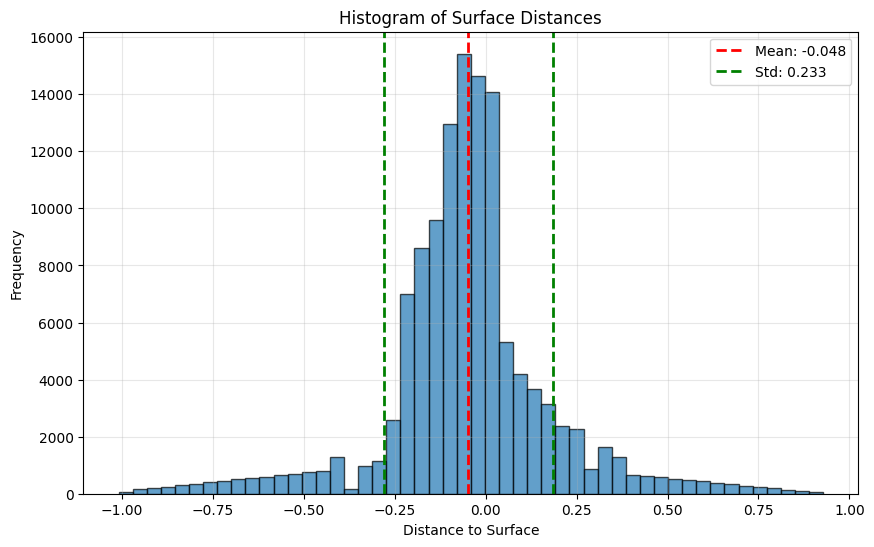

Mean distance: -0.048
Standard deviation: 0.233
Min distance: -1.010
Max distance: 0.928


In [14]:
from utils import plot_histogram
plot_histogram(distances)

In [12]:
margin = 0.01
voxel_data = (distances >= -margin) & (distances <= margin)
voxel_data = voxel_data.reshape(resolution, resolution, resolution)
voxel_data.shape

(50, 50, 50)

In [13]:
from trimesh.voxel import ops
trimesh = ops.matrix_to_marching_cubes(voxel_data, pitch=1.0)

def trimesh_to_pv(trimesh):
    vertices = trimesh.vertices
    faces = trimesh.faces
    # 첫번째 열에 3 추가
    faces = np.column_stack([np.full(faces.shape[0], 3), faces])
    return pv.PolyData(vertices, faces)

surface_mesh = trimesh_to_pv(trimesh)
surface_mesh.clean()
surface_mesh.plot()


Widget(value='<iframe src="http://localhost:32915/index.html?ui=P_0x7f3fbe566770_1&reconnect=auto" class="pyvi…

 - sdf 계산 정확도가 많이 떨어지는 것?